In [ ]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
file = pd.read_csv(r'C:\Users\rohishah\Desktop\ML_Hackathon\predict_stores.csv')

In [3]:
file.head()

,FIPS,GROCPTH09,SUPERC09,SUPERCPTH09,CONVS09,CONVSPTH09,SPECS09,SPECSPTH09,WICS08,FFR09,...,SNAP_PART_RATE08,PCT_NSLP09,PCT_WIC09,PCT_CACFP09,SNAP_BBCE09,SNAP_OAPP09,PCT_DIABETES_ADULTS08,PCT_OBESE_ADULTS08,RECFAC09,RECFACPTH09
0,1001,0.1,1,0.0,29,0.5,2,0.0,6,30,...,67,12.3,3.0,0.9,0,0.0,11.4,31.5,4,0.1
1,1003,0.1,6,0.0,119,0.7,21,0.1,25,112,...,67,12.3,3.0,0.9,0,0.0,9.8,26.2,18,0.1
2,1005,0.2,0,0.0,14,0.5,2,0.1,6,21,...,67,12.3,3.0,0.9,0,0.0,13.6,37.6,1,0.0
3,1007,0.3,1,0.0,19,0.8,0,0.0,6,7,...,67,12.3,3.0,0.9,0,0.0,11.1,32.3,1,0.0
4,1009,0.1,1,0.0,31,0.5,2,0.0,10,24,...,67,12.3,3.0,0.9,0,0.0,11.4,31.9,3,0.1


In [4]:
file = file.reindex(np.random.permutation(file.index))

In [5]:
file['POP_2009'] = file['POP_2009']/1000

In [6]:
Stores_data_frame = file[['POP_2009','RECFACPTH09','FARM_TO_SCHOOL09','METRO13','PER_CAPITA_INCOME','GROC09','FFR09','FSR09']]

In [7]:
Stores_data_frame.head()

,POP_2009,RECFACPTH09,FARM_TO_SCHOOL09,METRO13,PER_CAPITA_INCOME,GROC09,FFR09,FSR09
495,140.8,0.1,0.0,1,28457,13,61,53
914,25.9,0.0,0.0,0,32065,2,16,16
599,15.5,0.0,0.0,0,34604,3,11,9
2251,144.2,0.1,0.0,1,32759,31,100,78
2146,69.5,0.1,0.0,1,32338,7,34,39


In [8]:
train_data_frame = Stores_data_frame.head(2000)

In [9]:
train_data_frame.head()

,POP_2009,RECFACPTH09,FARM_TO_SCHOOL09,METRO13,PER_CAPITA_INCOME,GROC09,FFR09,FSR09
495,140.8,0.1,0.0,1,28457,13,61,53
914,25.9,0.0,0.0,0,32065,2,16,16
599,15.5,0.0,0.0,0,34604,3,11,9
2251,144.2,0.1,0.0,1,32759,31,100,78
2146,69.5,0.1,0.0,1,32338,7,34,39


In [10]:
testing_data_frame = Stores_data_frame.tail(1085)

In [11]:
testing_data_frame.head()

,POP_2009,RECFACPTH09,FARM_TO_SCHOOL09,METRO13,PER_CAPITA_INCOME,GROC09,FFR09,FSR09
578,3.8,0.0,0.0,0,38189,3,2,4
2901,71.7,0.2,0.0,1,35422,20,57,80
1773,447.4,0.1,0.0,1,47569,72,324,234
293,12.6,0.1,0.0,0,30394,4,11,6
526,66.4,0.0,0.0,0,29074,16,55,51


In [12]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [13]:
def train_model(learning_rate, steps, batch_size, input_feature):
    periods = 10
    steps_per_period = steps / periods
    my_feature_data = train_data_frame[['POP_2009','RECFACPTH09','FARM_TO_SCHOOL09','METRO13','PER_CAPITA_INCOME','FFR09','FSR09']]
    my_label = "GROC09"
    targets = train_data_frame[my_label]

      # Create feature columns.
    for my_feature in input_feature:
        feature_columns = [tf.feature_column.numeric_column(my_feature)]

      # Create input functions.
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
          feature_columns=feature_columns,
          optimizer=my_optimizer
      )

     # Train the model, but do so inside a loop so that we can periodically assess
      # loss metrics.
    print ("Training model...")
    print ("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        # Compute loss.
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))
        # Occasionally print the current loss.
        print(period, root_mean_squared_error)
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        
    print ("Model training finished.")

  # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    print (root_mean_squared_error)
    return linear_regressor

Training model...
RMSE (on training data):
0 84.95355840434945
1 72.919682280533
2 61.802524010919434
3 58.31507668594464
4 48.975028086251555
5 58.32501922061815
6 48.97782510006209
7 42.24238215018292
8 48.9792221998553
9 42.24081847825692
Model training finished.
42.24081847825692


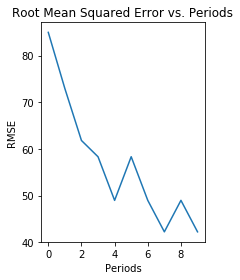

In [14]:
linear_regressor = train_model(
                learning_rate=0.01,
                steps=10,
                batch_size=1,
                input_feature= ['POP_2009','RECFACPTH09','FARM_TO_SCHOOL09','METRO13','PER_CAPITA_INCOME','FFR09','FSR09'])

In [15]:
 prediction_test_input_fn = lambda: my_input_fn(testing_data_frame[['POP_2009','RECFACPTH09','FARM_TO_SCHOOL09','METRO13','PER_CAPITA_INCOME','FFR09','FSR09']], testing_data_frame["GROC09"], num_epochs=1, shuffle=False)

In [16]:
test_prediction = linear_regressor.predict(input_fn=prediction_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_prediction])

In [17]:
root_mean_squared_error_test = math.sqrt(metrics.mean_squared_error(test_predictions, testing_data_frame["GROC09"]))

In [18]:
root_mean_squared_error_test

30.21428985386951